In [55]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

Đọc dữ liệu

In [56]:
btc_data = pd.read_csv('BTC-USD.csv')
eth_data = pd.read_csv('ETH-USD.csv')

Dữ liệu BTC-USD

In [57]:
btc_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/1/2019,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4.324201e+09
1,1/2/2019,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5.244857e+09
2,1/3/2019,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4.530215e+09
3,1/4/2019,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4.847965e+09
4,1/5/2019,3851.973877,3904.903076,3836.900146,3845.194580,3845.194580,5.137610e+09


Dữ liệu ETH-USD

In [58]:
eth_data.head()

,Date,Close-ETH
0,1/1/2019,140.819412
1,1/2/2019,155.047684
2,1/3/2019,149.135010
3,1/4/2019,154.581940
4,1/5/2019,155.638596


Kết hợp dữ liệu BTC và ETH

In [59]:
data = pd.merge(btc_data, eth_data, on='Date')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Close-ETH
0,1/1/2019,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4.324201e+09,140.819412
1,1/2/2019,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5.244857e+09,155.047684
2,1/3/2019,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4.530215e+09,149.135010
3,1/4/2019,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4.847965e+09,154.581940
4,1/5/2019,3851.973877,3904.903076,3836.900146,3845.194580,3845.194580,5.137610e+09,155.638596


**Dự đoán 30 ngày cho ETH bằng ARIMA**

In [60]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [61]:
eth_data = eth_data[['Date', 'Close-ETH']]
eth_data = eth_data.dropna() # Drop missing values
# eth_data = eth_data.reset_index(drop=True) # Reset the index
eth_data['Date'] = pd.to_datetime(eth_data['Date'])
eth_data.set_index('Date', inplace=True)

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(eth_data))
test_size = int(0.2 * len(eth_data))
val_size = len(eth_data) - train_size - test_size

train_data = eth_data[:train_size]
test_data = eth_data[train_size:train_size+test_size]
val_data = eth_data[train_size+test_size:]
print(eth_data)

              Close-ETH
Date                   
2019-01-01   140.819412
2019-01-02   155.047684
2019-01-03   149.135010
2019-01-04   154.581940
2019-01-05   155.638596
...                 ...
2023-03-27  1715.460815
2023-03-28  1772.785645
2023-03-29  1793.001831
2023-03-30  1792.737183
2023-03-31  1822.022095

[1551 rows x 1 columns]


In [62]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close-ETH'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12740.118, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12745.833, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12734.071, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12734.325, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12745.612, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=12736.071, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12736.076, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12738.085, Time=0.53 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=12734.293, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.663 seconds


ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True)

In [63]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close-ETH'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close-ETH'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [64]:
import datetime
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  eth_data.index[-1]
print(last_index)
next_30_days_index_eth = pd.date_range(start=last_index + datetime.timedelta(days=1), periods=30, freq='D')
print(next_30_days_index_eth)
# Create an array of 30 consecutive integers starting from last_index
x_next_30_days_eth = np.array(next_30_days_index_eth).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days_eth = model.predict(n_periods=len(x_next_30_days_eth)) 

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days_eth)

2023-03-31 00:00:00
DatetimeIndex(['2023-04-01', '2023-04-02', '2023-04-03', '2023-04-04',
               '2023-04-05', '2023-04-06', '2023-04-07', '2023-04-08',
               '2023-04-09', '2023-04-10', '2023-04-11', '2023-04-12',
               '2023-04-13', '2023-04-14', '2023-04-15', '2023-04-16',
               '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20',
               '2023-04-21', '2023-04-22', '2023-04-23', '2023-04-24',
               '2023-04-25', '2023-04-26', '2023-04-27', '2023-04-28',
               '2023-04-29', '2023-04-30'],
              dtype='datetime64[ns]', freq='D')
Predicted closing prices for the next 30 days:
[3936.4627134  3940.05033432 3943.52911272 3947.02011189 3950.50973893
 3953.99952002 3957.48928382 3960.97904956 3964.46881509 3967.95858063
 3971.44834618 3974.93811172 3978.42787727 3981.91764281 3985.40740836
 3988.8971739  3992.38693945 3995.87670499 3999.36647054 4002.85623608
 4006.34600163 4009.83576717 4013.32553272 4016.81529826 402

Validation RMSE: 2749.1414402514743
Testing RMSE: 2526.7777766949
Validation MAPE: 1.9272527054096444
Testing MAPE: 1.4008010123681098


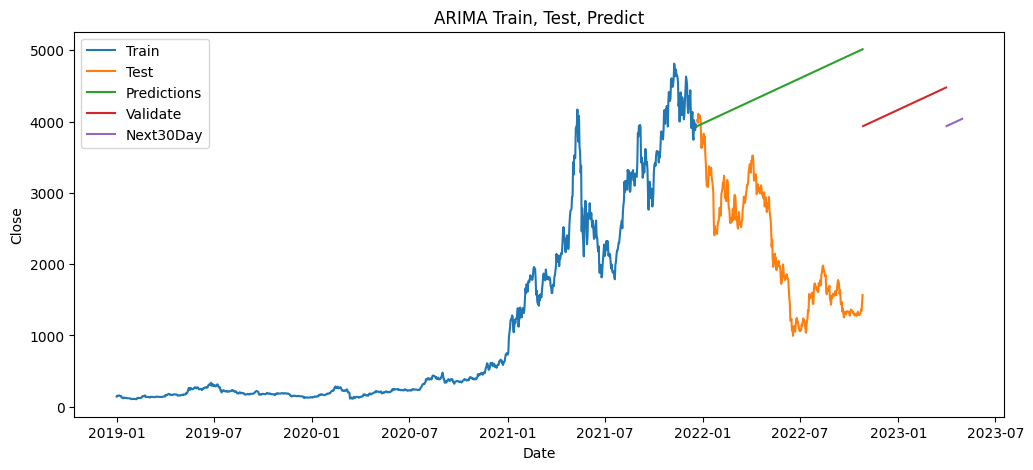

In [65]:
# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_mape = np.mean(np.abs(y_pred_val - y_val)/np.abs(y_val))  # MAPE
test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))  # MAPE
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
# 9.Vẽ hình
plt.figure(figsize=(12,5), dpi=100)
plt.ylabel('Close');
plt.xlabel('Date');
plt.title('ARIMA Train, Test, Predict')
plt.plot(train_data.index, train_data['Close-ETH'])
plt.plot(test_data.index, test_data['Close-ETH'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
# plt.plot(last_data,y_next_30_days)
plt.plot(next_30_days_index_eth,y_next_30_days_eth)

plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

**SARIMAX**

**<h3>Dự đoán ARIMAX 7-2-1</h3>**

In [66]:

# data = data.reset_index(drop=True) # Reset the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[['Close', 'Close-ETH']]
data = data.dropna() # Drop missing values

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]
print(len(train_data))
print(len(test_data))
print(len(val_data))

1085
310
156


In [67]:
from pmdarima.arima import auto_arima
train_exog = train_data[["Close-ETH"]]
model = auto_arima(train_data.Close, 
                   seasonal = True,
                   m=12,
                      test='adf',       # use adftest to find      
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,  
                      stepwise=True,
                      exogenous= train_exog)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=18317.265, Time=12.99 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=18334.592, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=18328.984, Time=0.90 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=18329.566, Time=0.97 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=18333.913, Time=0.07 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=18331.519, Time=12.05 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=13.62 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=18319.241, Time=21.09 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=21.05 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=18326.915, Time=2.01 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=18323.835, Time=13.48 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=inf, Time=21.00 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=23.22 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=18328.973, Time=4.12 sec
 ARIMA(2,1,1)(1,0,1)[

In [68]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model= SARIMAX(train_data.Close, 
 exog=train_exog,
 order=(2, 1, 2),
  seasonal_order=(1, 0, 1, 12),
 enforce_invertibility=False, enforce_stationarity=False)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [69]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
test_exog = test_data[['Close-ETH']]
model_fit = model.fit()
# y_pred = model.predict(n_periods=len(y_test))
y_pred = model_fit.forecast(steps=len(y_test), exog=test_exog)
print(y_pred)

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
val_exog = val_data[['Close-ETH']]
print(val_exog)
y_pred_val =  model_fit.forecast(steps=len(y_val), exog=val_exog)
print(y_pred_val)

2021-12-21    47666.783779
2021-12-22    47228.136227
2021-12-23    48403.763364
2021-12-24    47795.038372
2021-12-25    48200.121567
                  ...     
2022-10-22    21078.875765
2022-10-23    21553.316456
2022-10-24    21375.226946
2022-10-25    22501.451925
2022-10-26    23514.099324
Freq: D, Name: predicted_mean, Length: 310, dtype: float64
              Close-ETH
Date                   
2022-10-27  1514.374878
2022-10-28  1555.477905
2022-10-29  1619.698486
2022-10-30  1590.783325
2022-10-31  1572.714478
...                 ...
2023-03-27  1715.460815
2023-03-28  1772.785645
2023-03-29  1793.001831
2023-03-30  1792.737183
2023-03-31  1822.022095

[156 rows x 1 columns]
2021-12-21    23476.622250
2021-12-22    23803.131529
2021-12-23    24383.191647
2021-12-24    24074.854988
2021-12-25    23868.235529
                  ...     
2022-05-21    24951.426476
2022-05-22    25504.802466
2022-05-23    25699.956101
2022-05-24    25697.401286
2022-05-25    25980.098430
Freq: D, Na

In [70]:
import datetime
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  data.index[-1]
print(last_index)
# last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
next_30_days_index = pd.date_range(start=last_index + datetime.timedelta(days=1), periods=30, freq='D')
print(next_30_days_index)
# Create an array of 30 consecutive integers starting from last_index
# x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
x_next_30_days = np.array(next_30_days_index).reshape(-1, 1)



# Predict the closing prices for the next 30 days
y_next_30_days = model_fit.forecast(steps=len(x_next_30_days), exog = y_next_30_days_eth) 

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

2023-03-31 00:00:00
DatetimeIndex(['2023-04-01', '2023-04-02', '2023-04-03', '2023-04-04',
               '2023-04-05', '2023-04-06', '2023-04-07', '2023-04-08',
               '2023-04-09', '2023-04-10', '2023-04-11', '2023-04-12',
               '2023-04-13', '2023-04-14', '2023-04-15', '2023-04-16',
               '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20',
               '2023-04-21', '2023-04-22', '2023-04-23', '2023-04-24',
               '2023-04-25', '2023-04-26', '2023-04-27', '2023-04-28',
               '2023-04-29', '2023-04-30'],
              dtype='datetime64[ns]', freq='D')
Predicted closing prices for the next 30 days:
2021-12-21    46857.859972
2021-12-22    46822.220276
2021-12-23    46815.919113
2021-12-24    46820.410140
2021-12-25    46821.901964
2021-12-26    46821.886064
2021-12-27    46835.522952
2021-12-28    46869.334618
2021-12-29    46895.290479
2021-12-30    46912.407129
2021-12-31    46921.233750
2022-01-01    46942.332231
2022-01-02    46960.

Validation RMSE: 2659.9271741563284
Testing RMSE: 3351.3736206179988
Validation MAPE: 0.1264265092729444
Testing MAPE: 0.09465633963354221


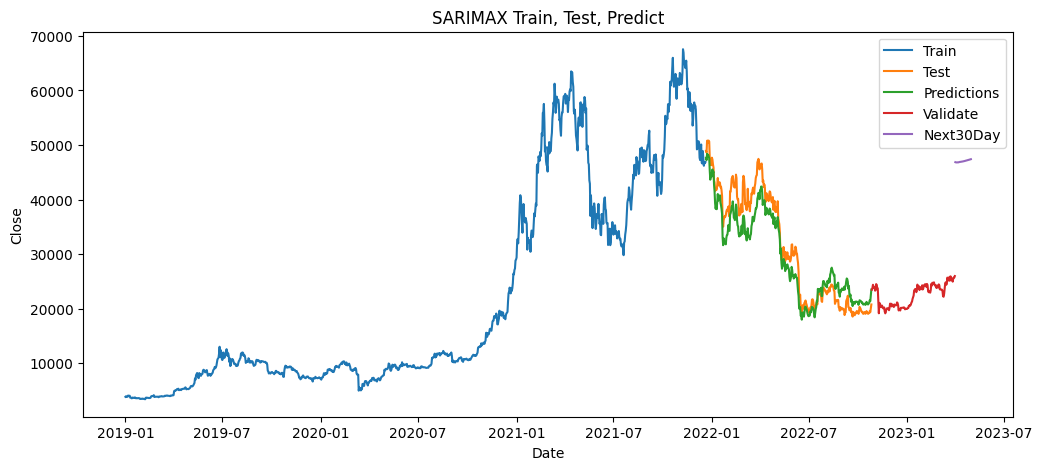

In [71]:
# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_mape = np.mean(np.abs(y_pred_val - y_val)/np.abs(y_val))  # MAPE
test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))  # MAPE
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)



# 9.Vẽ hình
plt.figure(figsize=(12,5), dpi=100)
plt.ylabel('Close');
plt.xlabel('Date');
plt.title('SARIMAX Train, Test, Predict')
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
# plt.plot(last_data,y_next_30_days)
plt.plot(next_30_days_index,y_next_30_days)

plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()